In [205]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics as st
from IPython import display
from mpl_toolkits.mplot3d import Axes3D
import pathlib


In [206]:
initial_count = 0
for path in pathlib.Path("./imagefile/tryout").iterdir():
    if path.is_file():
        initial_count += 1

print(initial_count)

280


In [207]:
img=cv2.imread('./imagefile/tryout/img_000.jpg')

#img_resize = cv2.resize(img, dsize=[1920,1080], fx=None, fy=None)

#cv2.imwrite(img_path,img)

# HSVに変換
RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(RGB, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(hsv,cv2.CV_64F,1,0,ksize=5)

#plt.imshow(sobelx)
cv2.imwrite("./after/test.jpg",sobelx)

True

In [208]:
im_out = cv2.imread("./after/test.jpg")

# 画像をグレースケールで読み出しオブジェクトimg_grayに代入
img_gray = cv2.cvtColor(im_out,cv2.COLOR_BGR2GRAY)
# img_grayを平均化領域9x9で平均化処理しimg_blurに代入
img_blur = cv2.blur(img_gray,(9,9)) 

#閾値
threshold=120

# オブジェクトimg_blurを閾値thresholdで反転二値化しimg_binaryに代入
ret, img_binary= cv2.threshold(img_blur, threshold, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("./after/image0.jpg",img_binary) 
# img_binaryを輪郭抽出
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
#plt.imshow(img_binary)

0 外接矩形の座標
[[ 715 1078]
 [ 731 1051]
 [ 740 1056]
 [ 724 1083]] 

1 外接矩形の座標
[[1827 1026]
 [1895 1026]
 [1895 1079]
 [1827 1079]] 

2 外接矩形の座標
[[1886  989]
 [1919  989]
 [1919 1079]
 [1886 1079]] 

3 外接矩形の座標
[[ 814  965]
 [ 851  963]
 [ 856 1078]
 [ 818 1080]] 

4 外接矩形の座標
[[  0 579]
 [ 12 579]
 [ 12 721]
 [  0 721]] 

5 外接矩形の座標
[[1131    0]
 [1137   -1]
 [1165   73]
 [1160   75]] 

6 外接矩形の座標
[[   0 1078]
 [   0    0]
 [1918    0]
 [1918 1078]] 

7 外接矩形の座標
[[1284 1059]
 [1284 1044]
 [1290 1044]
 [1290 1059]] 

8 外接矩形の座標
[[ 588 1037]
 [ 594 1034]
 [ 602 1052]
 [ 596 1055]] 

9 外接矩形の座標
[[ 355 1034]
 [ 382 1024]
 [ 384 1031]
 [ 357 1041]] 

10 外接矩形の座標
[[ 705 1025]
 [ 724 1022]
 [ 729 1052]
 [ 710 1055]] 

11 外接矩形の座標
[[ 384 1031]
 [ 384 1023]
 [ 398 1023]
 [ 398 1031]] 

12 外接矩形の座標
[[ 562  988]
 [ 577  984]
 [ 593 1050]
 [ 578 1054]] 

13 外接矩形の座標
[[ 486  991]
 [ 493  984]
 [ 514 1005]
 [ 507 1012]] 

14 外接矩形の座標
[[497 978]
 [501 974]
 [513 986]
 [509 990]] 

15 外接矩形の座標
[[616 975]
 [626 973]
 [6

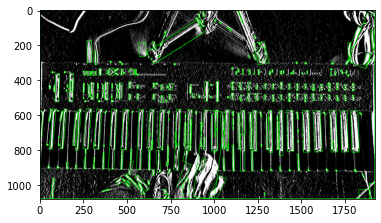

In [209]:
# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda y: cv2.contourArea(y) > 50, contours))

ylen=[]

ID=0
for i in contours:
    y=[]
    rect = cv2.minAreaRect(i)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img = cv2.drawContours(im_out,[box],0,(0,255,0),2)
    #cv2.imwrite("./after/gaisetu"+str(ID)+".jpg",img)  
    plt.imshow(img)

    # 外接矩形の座標、回転角の表示
    print(str(ID),'外接矩形の座標')
    print(box,"\n")
    #print('回転角:')
    #print(rect[2])
   

    #各輪郭の左端、右端を取得
    for  r in box:
        y+=[r[1]]
        
    ylen+=[[max(min(y),0),min(max(y),1080)]]
    ID+=1

In [210]:
hst=[0]*1080
i=0
while i<len(ylen):
    j=ylen[i][0]
    while j<ylen[i][1]:
        hst[j]+=1
        j+=1
    i+=1

In [211]:
#疑似的に積分し、最も輪郭が多い範囲を取得
i=0
hst+=[-1]
menseki=[]
ykenban=[]
while i<1080:
    sekibun=0
    while hst[i]<20 and hst[i]!=-1:
        i+=1
    ystart=i
    while hst[i]>=20 and hst[i]!=-1:
        sekibun+=hst[i]
        i+=1
    yend=i
    ykenban+=[[ystart,yend]]
    menseki+=[sekibun]
print(ykenban)
print(menseki)
ind=menseki.index(max(menseki))
print(ykenban[ind])

[[346, 370], [419, 460], [478, 512], [513, 517], [572, 813], [844, 860], [863, 867], [868, 921], [1080, 1080]]
[720, 1436, 1087, 82, 8966, 322, 80, 1195, 0]
[572, 813]


(1080, 1920)


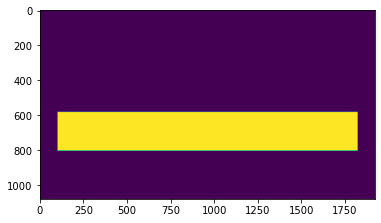

In [212]:
# マスク用単一色画像を作成



#若干の調整
yy = math.floor(1.5*(ykenban[ind][1]-ykenban[ind][0])) 
#height = yy*5
height = ykenban[ind][1]-ykenban[ind][0]


imgMask = np.full((1, 1, 1), 1, dtype=np.uint8)
imgMask_resize = cv2.resize(imgMask, dsize=[1920,1080], fx=None, fy=None)

imgMask_resize2 = cv2.resize(imgMask, dsize=[1920,1080], fx=None, fy=None)

print(imgMask_resize.shape)

# マスク範囲を四角形で描画
boxFromX = 0 #マスク範囲開始位置 X座標
boxFromY = ykenban[ind][0]  #マスク範囲開始位置 Y座標
boxToX = 1920 #マスク範囲終了位置 X座標
boxToY = boxFromY + height #マスク範囲終了位置 Y座標

#cv2.rectangle(imgMask_resize, (boxFromX, boxFromY), (boxToX, boxToY),(255), cv2.FILLED)

cv2.rectangle(imgMask_resize , (boxFromX+100, boxFromY+10), (boxToX-100, boxToY-10),(255), cv2.FILLED)
cv2.rectangle(imgMask_resize2, (boxFromX+100, boxFromY+10), (boxToX-100, boxFromY+int((yy-10)/2)),(255), cv2.FILLED)

# マスク結果画像を保存
cv2.imwrite("./mask/testMaskImg.jpg", imgMask_resize)    #黒鍵の長さ
cv2.imwrite("./mask/testMaskImg2.jpg", imgMask_resize2)  #白鍵の長さ
plt.imshow(imgMask_resize)
#plt.imshow(imgMask_resize2)

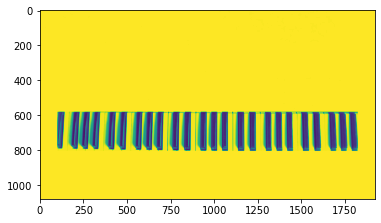

In [213]:
im_1 = cv2.imread('./imagefile/tryout/img_000.jpg', cv2.IMREAD_COLOR)
im_1 = cv2.cvtColor(im_1,cv2.COLOR_BGR2GRAY)
imgMask_resize_not = cv2.bitwise_not(imgMask_resize)
im_out = cv2.bitwise_or(im_1, imgMask_resize_not)
cv2.imwrite('./after/out.jpg', im_out)
plt.imshow(im_out)

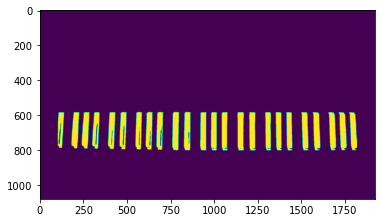

In [214]:
# 画像をグレースケールで読み出しオブジェクトimg_grayに代入
#img_gray = cv2.cvtColor(im_out,cv2.COLOR_BGR2GRAY)
# img_grayを平均化領域9x9で平均化処理しimg_blurに代入
img_blur = cv2.blur(im_out,(9,9)) 

#閾値
threshold=100

# オブジェクトimg_blurを閾値thresholdで反転二値化しimg_binaryに代入
ret, img_binary= cv2.threshold(img_blur, threshold, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("./after/image0.jpg",img_binary) 
# img_binaryを輪郭抽出
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
plt.imshow(img_binary)

0 外接矩形の座標
[[1770  584]
 [1806  582]
 [1820  799]
 [1784  801]] 

1 外接矩形の座標
[[1711  584]
 [1747  582]
 [1759  799]
 [1723  801]] 

2 外接矩形の座標
[[1652  584]
 [1687  582]
 [1699  799]
 [1664  801]] 

3 外接矩形の座標
[[1562  584]
 [1598  582]
 [1607  800]
 [1572  801]] 

4 外接矩形の座標
[[1496  584]
 [1532  582]
 [1540  800]
 [1505  801]] 

5 外接矩形の座標
[[1410  584]
 [1441  583]
 [1446  800]
 [1415  801]] 

6 外接矩形の座標
[[1350  584]
 [1381  583]
 [1384  800]
 [1353  801]] 

7 外接矩形の座標
[[1289  584]
 [1321  583]
 [1325  800]
 [1293  801]] 

8 外接矩形の座標
[[1198  584]
 [1232  583]
 [1234  800]
 [1199  801]] 

9 外接矩形の座標
[[1132  584]
 [1167  584]
 [1167  801]
 [1132  801]] 

10 外接矩形の座標
[[1042  584]
 [1074  584]
 [1074  801]
 [1042  801]] 

11 外接矩形の座標
[[917 800]
 [919 583]
 [953 584]
 [950 801]] 

12 外接矩形の座標
[[297 790]
 [306 582]
 [341 584]
 [331 792]] 

13 外接矩形の座標
[[237 789]
 [247 582]
 [283 584]
 [272 791]] 

14 外接矩形の座標
[[177 788]
 [188 582]
 [224 584]
 [214 790]] 

15 外接矩形の座標
[[ 96 786]
 [105 582]
 [137 584]
 [128 78

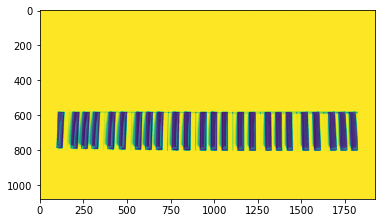

In [215]:
# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 1000, contours))


xleft=[]
xright=[]

ID=0
for i in contours:
    x=[]
    rect = cv2.minAreaRect(i)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img = cv2.drawContours(im_out,[box],0,(0,255,0),2)
    cv2.imwrite("./after/gaisetu"+str(ID)+".jpg",img)  
    plt.imshow(img)

    # 外接矩形の座標、回転角の表示
    print(str(ID),'外接矩形の座標')
    print(box,"\n")
    #print('回転角:')
    #print(rect[2])
   

    #各輪郭の左端、右端を取得
    for  r in box:
        x+=[r[0]]
    xleft +=[min(x)]
    xright+=[max(x)]

    ID+=1

In [216]:
def bubble_sort(arr):
    change = True
    while change:
        change = False
        for i in range(len(arr) - 1):
            if arr[i] > arr[i + 1]:
                arr[i], arr[i + 1] = arr[i + 1], arr[i]
                change = True
    return arr

In [217]:
xleft=bubble_sort(xleft)
xright=bubble_sort(xright)
print(xleft)
print(xright)

kokken=[[xleft[0],xright[0]]]
i=1
while i<len(xleft):
    kokken+=[[xleft[i],xright[i]]]
    i+=1


[96, 177, 237, 297, 388, 453, 545, 604, 665, 756, 824, 917, 979, 1042, 1132, 1198, 1289, 1350, 1410, 1496, 1562, 1652, 1711, 1770]
[137, 224, 283, 341, 431, 497, 584, 645, 706, 797, 863, 953, 1013, 1074, 1167, 1234, 1325, 1384, 1446, 1540, 1607, 1699, 1759, 1820]


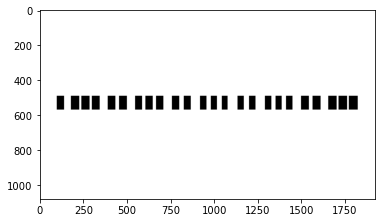

In [218]:
i=0
white = cv2.imread('./mask/white.jpg')
white_resize = cv2.resize(white, dsize=[1920,1080], fx=None, fy=None)
base=white_resize

while i<len(xleft):
    cv2.rectangle(base,
              (xleft[i], 568),
              (xright[i], 490),
              (0, 0, 0),
              thickness=-1,
              lineType=cv2.LINE_4,
              shift=0)

    i+=1
plt.imshow(base)

In [219]:
#端っこを追加
xright=[boxFromX+100]+xright
xleft =xleft+[boxToX-100]

In [220]:
#白い部分の座標
hakkenkari=[[xright[0],xleft[0]]]
i=1
while i<len(xleft):
    hakkenkari+=[[xright[i],xleft[i]]]
    i+=1
print(hakkenkari)

[[100, 96], [137, 177], [224, 237], [283, 297], [341, 388], [431, 453], [497, 545], [584, 604], [645, 665], [706, 756], [797, 824], [863, 917], [953, 979], [1013, 1042], [1074, 1132], [1167, 1198], [1234, 1289], [1325, 1350], [1384, 1410], [1446, 1496], [1540, 1562], [1607, 1652], [1699, 1711], [1759, 1770], [1820, 1820]]


In [221]:
mean=st.mean(xleft)-st.mean(xright)


In [222]:



#白鍵の正確な座標
i=0
j=0
hakken=[]
while i<len(hakkenkari):
    haklen=hakkenkari[i][1]-hakkenkari[i][0]
    if  haklen>mean:#別のところの値使いたい
        hakken+=[[hakkenkari[i][0],math.floor(hakkenkari[i][0]+haklen/2)]]+[[math.ceil(hakkenkari[i][0]+haklen/2),hakkenkari[i][1]]]
        
    else:
        hakken+=[[hakkenkari[i][0],hakkenkari[i][1]]]
    i+=1
print(hakken)

[[100, 96], [137, 157], [157, 177], [224, 237], [283, 297], [341, 364], [365, 388], [431, 453], [497, 521], [521, 545], [584, 604], [645, 665], [706, 731], [731, 756], [797, 824], [863, 890], [890, 917], [953, 979], [1013, 1042], [1074, 1103], [1103, 1132], [1167, 1182], [1183, 1198], [1234, 1261], [1262, 1289], [1325, 1350], [1384, 1410], [1446, 1471], [1471, 1496], [1540, 1562], [1607, 1629], [1630, 1652], [1699, 1711], [1759, 1770], [1820, 1820]]


[[100, 96], [137, 157], [157, 177], [224, 237], [283, 297], [341, 364], [365, 388], [431, 453], [497, 521], [521, 545], [584, 604], [645, 665], [706, 731], [731, 756], [797, 824], [863, 890], [890, 917], [953, 979], [1013, 1042], [1074, 1103], [1103, 1132], [1167, 1182], [1183, 1198], [1234, 1261], [1262, 1289], [1325, 1350], [1384, 1410], [1446, 1471], [1471, 1496], [1540, 1562], [1607, 1629], [1630, 1652], [1699, 1711], [1759, 1770], [1820, 1820]]


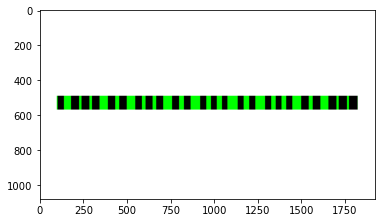

In [223]:
i=0

base=white_resize
while i<len(hakken):
    l=hakken[i][0]
    r=hakken[i][1]
    
    cv2.rectangle(base,
              (l,568),
              (r, 490),
              (0,255,0),
              thickness=-1,
              lineType=cv2.LINE_4,
              shift=0)
    i+=1
cv2.imwrite("./after/hakken.jpg",base)
plt.imshow(base)
print(hakken)


In [224]:
#音の高さを検出
n=0 #右から何番目かを入力　左端は0 このプログラムだと0がシ
i=n

nanabit=[]
while i<7+n:
    print(hakken[i+1][0],hakken[i][1])
    if hakken[i+1][0]-hakken[i][1]>1:
        nanabit+=[0]
    else :
        nanabit+=[1]+[1]
        i+=1
    i+=1
if len(nanabit)>7:
    nanabit.pop(-1)
    nanabit[6]=0
print(nanabit)
i=6
tensin=0
k=1
while i>=0:
    tensin+=nanabit[i]*k
    k*=2
    i-=1

print(tensin)

137 96
157 157
283 237
341 297
365 364
[0, 1, 1, 0, 0, 1, 1]
51


In [225]:
if tensin==24:hstart=0
if tensin==51:hstart=1
if tensin==102:hstart=2
if tensin==12:hstart=3
if tensin==27:hstart=4
if tensin==54:hstart=5
if tensin==108:hstart=6
print(hstart)


1


In [226]:
#オクターブ
n=2

In [227]:
i=0
doremi=["C","D","E","F","G","A","B"]
hakkendoremi=[]
while i<len(hakken):
    hakkendoremi+=[str(doremi[(hstart+i)%7])+str(math.floor((hstart+i)/7)+n)]
    i+=1
print(hakkendoremi)

['D2', 'E2', 'F2', 'G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5', 'C6', 'D6', 'E6', 'F6', 'G6', 'A6', 'B6', 'C7']


True

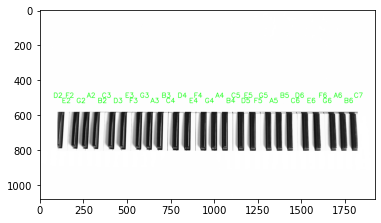

In [228]:
#base2 = cv2.imread("./after/white_resize.jpg")
#base2=im_out
base3=cv2.imread("./after/out.jpg")
plt.imshow(base3)
i=0
while i<len(hakken):
    t=i%2*30
    cv2.putText(base3,
            text=(str(doremi[(hstart+i)%7])+str(math.floor((hstart+i)/7)+n)),
            org=(math.floor((hakken[i][1]+hakken[i][0])/2)-22,500+t),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.3,
            color=(0, 255, 0),
            thickness=2,
            lineType=cv2.LINE_4)
    i+=1

plt.imshow(base3)
cv2.imwrite("./after/doremi.jpg",base3)

In [229]:
if hstart==0 or hstart==6:bstart=0
if hstart==1 :bstart=1
if hstart==2 or hstart==3:bstart=2
if hstart==4 : bstart=3
if hstart==5 : bstart=4
print(hstart,bstart)

1 1


In [230]:
sharp=["C#","D#","F#","G#","A#"]
if hstart==6:
    n+=1
i=0
kokkendoremi=[]
while i<len(kokken):
    kokkendoremi+=[str(sharp[(bstart+i)%5])+str(math.floor((bstart+i)/5)+n)]
    i+=1
print(kokkendoremi)

['D#2', 'F#2', 'G#2', 'A#2', 'C#3', 'D#3', 'F#3', 'G#3', 'A#3', 'C#4', 'D#4', 'F#4', 'G#4', 'A#4', 'C#5', 'D#5', 'F#5', 'G#5', 'A#5', 'C#6', 'D#6', 'F#6', 'G#6', 'A#6']


True

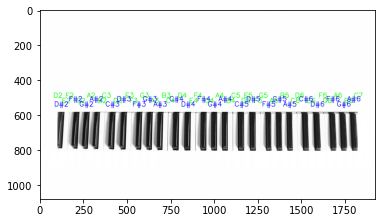

In [231]:
i=0
while i<len(kokken):
    t=i%2*30
    cv2.putText(base3,
            text=(str(sharp[(bstart+i)%5])+str(math.floor((bstart+i)/5)+n)),
            org=(math.floor((kokken[i][1]+kokken[i][0])/2)-35,550-t),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.3,
            color=(0, 0, 255),
            thickness=2,
            lineType=cv2.LINE_4)
    i+=1

plt.imshow(base3)
cv2.imwrite("./after/doremi.jpg",base3)

In [238]:
num = 0
hakkenfocus = []
mask = cv2.imread('./mask/kenbanmask.jpg')
while(1):
    
    img_number = num
    if img_number < 100:
        if img_number < 10:
            img_number = "0"+str(img_number)
        img_number = "0"+str(img_number)

    img1 = cv2.imread('./imagefile/tryout/img_'+str(img_number)+'.jpg')

    if img1 is None:
        break

    i=0
    sumlist = []
    while i<len(hakken):
        img2 = img1[boxFromY+10:boxToY-10,hakken[i][0]+5:hakken[i][1]-5]
        if i == 15: cv2.imwrite('./imagefile/kenban/img_'+str(img_number)+'.jpg',img2)
        #sumlist += [np.ndarray.sum(img2.ravel())]
        sumlist += [np.average(img2.ravel(), axis = None, weights = None, returned = False)]
        i+=1

    hakkenfocus += [sumlist]

    num += 1

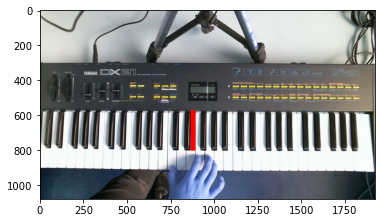

In [239]:
img11 = cv2.imread('./imagefile/tryout/img_000.jpg')
cv2.rectangle(img11 , (hakken[15][0],boxFromY),(hakken[15][1], boxToY-10),(255), cv2.FILLED)
plt.imshow(img11)

In [240]:
#転置
hakkenfocus_t = np.array(hakkenfocus).T.tolist()

In [241]:
#ミとシを特定しておく

k = 0
mi_and_si = []
for i in hakkendoremi:
    if (i[0] == 'E') or (i[0] == 'B'):mi_and_si += [k]

    k += 1

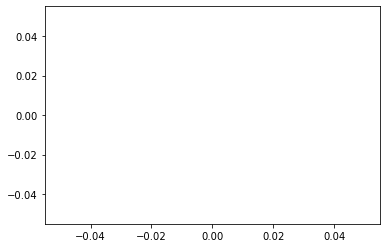

In [242]:
import statistics as st

num=0
hakkenrange = []

finaldata = []

for i in hakkenfocus_t:
    img_number = num
    if img_number < 100:
        if img_number < 10:
            img_number = "0"+str(img_number)
        img_number = "0"+str(img_number)


    #ミとシ、その他で閾値を変える
    if num in mi_and_si:
        hakkenborder = hakkenfocus_t[num][0]*0.95
        x = [hakkenborder]*initial_count
    else:
        hakkenborder = hakkenfocus_t[num][0]*0.9
        x = [hakkenborder]*initial_count

    ccc = []
    for j in i:
        if j < hakkenborder:ccc += [1]
        else: ccc += [0]
    finaldata += [ccc]
    
    plt.clf()
    plt.plot(i)
    plt.plot(x)
    plt.savefig('./imagefile/plt/img_'+str(img_number)+'.jpg')

    hakkenrange += [max(i)-min(i)]

    num+=1
    



In [243]:
#転置
finaldata_t = np.array(finaldata).T.tolist()

for i in range(0,len(finaldata_t)):
    print(finaldata_t[i])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 